In [1]:
import pickle
import pandas as pd
import re
import numpy as np
import datetime

from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

from nltk.tokenize import word_tokenize
import torch
from tqdm.notebook import tqdm

import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
brand = 'maxima'

In [3]:
def cleanMessage(df):
    newLine ="\\n|\\r"
    urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    numbers = '\d+((\.|\-)\d+)?'
    mentions = '\B\@([\w\-]+)'
    hashtag = '#'
    whitespaces = '\s+'
    leadTrailWhitespace = '^\s+|\s+?$'

    df['clean_message'] = df['message']
    df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
    df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
    df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
    df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
    df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
    df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
    df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

In [4]:
def readCsv(brand):
    tweets = pd.read_csv('./../peopleTweets/'+brand+'.csv')
    tweets['brand'] = brand
#     for index, row in brandTweets.iterrows():
#         if not(np.isnan(row['label'])):
#             row['label'] = int(row['label'])
    cleanMessage(tweets)
    return tweets

In [5]:
brandTweets = readCsv(brand)
brandTweets.shape[0]

5361

In [6]:
def convertDates(df):
    dates = []
    for index, row in df.iterrows():
        date_no_0 = row['createdAt'].replace('+00:00','')
        dates.append(datetime.datetime.strptime(date_no_0, '%Y-%m-%dT%H:%M:%S').strftime('%Y,%m,%d'))

    df["date"] = dates

In [7]:
convertDates(brandTweets)

In [8]:
# Tokenizer

tokenizer = BertTokenizer.from_pretrained('./lvBERT/lvbert_pytorch/', do_lower_case=False)

In [9]:
unk_tokens = [('^vi', 34), ('^ai', 30), ('^el', 22), ('(', 19), ('^il', 19), ('–', 17), ('^la', 17), ('^na', 17), ('€', 15), ('^ma', 15), ('^ri', 13), ('+', 11), ('X', 11), (':(', 8), ('Ļoti', 8), ('^ju', 8), ('🇱🇻', 7), ('&amp;', 6), ('👉', 6), ('🤔', 5), ('MAXIMA', 5), ('🎄', 5), ('€.', 4), ('😉', 4), ('^nn', 4), ('😅', 3), ('|', 3), ('(vai', 3), ('😊', 3), ('ibankā', 3), ('Žēl,', 3), ('You', 3), ('не', 3), ('за', 3), ('в', 3), ('❤️', 3), ('▶️', 3), ('uzs…', 2), ('YL-CSK.', 2), ('(un', 2), ('nav…', 2), ('😍', 2), ('(pat', 2), ('=', 2), ('🤗', 2), ('ļoooti', 2), ('(kaut', 2), ('XX', 2), ('“Valmiera/ORDO”', 2), ('😀', 2), ('🙄', 2), ('~', 2), ('🇷🇺', 2), ('(@', 2), ('*', 2), ('🤷\u200d♀️', 2), ('🤬', 2), ('✨', 2), ('(FKTK)', 2), ('(VDD)', 2), ('(sauksim', 2), ('Если', 2), ('🙂', 2), ('Yes,', 2), ('(+', 2), ('нас', 2), ('Добрый', 2), ('день!', 2), ('Pārbaudīsim.^la', 2), ('iOS', 2), ('“Maxima', 2), ('[..]', 2), ('XXX', 2), ('📲', 2), ('“potenciālie', 1), ('pasaules”', 1), ('(maijā),', 1), ('“', 1), ('slīpie”', 1), ('*FB', 1), ('konkursu*', 1), ('Pa…', 1), ('liepajatravel…', 1), ('✈️Izdevīgas', 1), ('laicīgi👍', 1), ('Qatar', 1), ('QR', 1), ('lidmašīnas😀😀😀', 1), ('(Rīgā:', 1), ('Havaś)', 1), ('Ņefiga', 1), ('👍🤗', 1), ('😥😥', 1), ('😵', 1), ('🇫🇷un', 1), ('krāšņumā…', 1), ('IONITY', 1), ('Ļooti', 1), ('skočs…', 1), ('nava😖', 1)]
most_common_values= [word for word, word_count in unk_tokens]

tokenizer.add_tokens(most_common_values, special_tokens=True)

100

In [10]:
# Model "lvBERT"

model = BertForSequenceClassification.from_pretrained('./lvBERT/lvbert_pytorch/',
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at ./lvBERT/lvbert_pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

In [11]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32104, 768)

In [12]:
# Load best model

model.load_state_dict(torch.load('./lvBERT/addUNKtokens/modelsUNK/finetuned_lvBERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [83]:
token_lens = []
for txt in list(brandTweets["clean_message"].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length = max(token_lens)
max_length

141

In [13]:
max_length = 141

In [13]:
# examples = [
#     'Tā ir brīnišķīga filma',
#     'Viss ir slikti',
#     '❤',
#     'Filma bija OK',
#     'Tā filma bija briesmīga...'
# ]
# token_lens = []
# for txt in list(examples):
#     tokens = tokenizer.encode(txt, max_length=512, truncation=True)
#     token_lens.append(len(tokens))
# max_length = max(token_lens)

In [84]:
# df = brandTweets[:5]
# df['label'].values

def predict(model, df, max_length):
    predictions = []
    progress_bar = tqdm(df.itertuples(), desc='Predicting:', leave=False, disable=False)
    for row in progress_bar:
        if (np.isnan(row.label)):
            enc = tokenizer.encode(
                row.clean_message,
                add_special_tokens=True, 
                return_attention_mask=True, 
                padding='max_length',
                truncation=True,
                max_length=max_length, 
                return_tensors='pt'
            )
            outputs = model(enc)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            predictions.append(np.argmax(logits, axis=1).flatten()[0])
        else:
            predictions.append(int(row.label))
    return predictions

# predictions = predict(model, df, max_length)
# print(predictions)

In [86]:
predictions = predict(model, brandTweets, max_length)

Predicting:: 0it [00:00, ?it/s]

In [ ]:
print(predictions)

In [87]:
brandTweets["lvbert_label"] = predictions
brandTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,monitoringObjectId1,monitoringObjectId2,queryId,sentiment,retweetCount,label,brand,clean_message,date,lvbert_label
0,@presesklubs @Silina_Elina @ZarinsI @AndrisSpr...,1483990,925746406169641000,2017-11-01T17:28:37,lv,9.257205e+17,4.272831e+09,presesklubs,990886668,Rainers Meiers,...,386,386,625.0,NaN,0,0.0,rimi,MENTION MENTION MENTION MENTION Cik produktīva...,"2017,11,01",0
1,"I'm at Rimi ""Kalnciema"" - @mansrimi in Riga, L...",1498061,926103114477920300,2017-11-02T17:06:03,it,NaN,NaN,NaN,93444470,Iveta Sīle,...,198,198,437.0,NaN,0,NaN,rimi,"I'm at Rimi ""Kalnciema"" - MENTION in Riga, Lat...","2017,11,02",0
2,"@Tele2Latvia pie jums tikai tad, kad mani izme...",1506975,926448378124361700,2017-11-03T15:58:00,lv,9.264411e+17,3.843552e+07,Tele2Latvia,334622732,digidigidong,...,195,195,434.0,NaN,0,NaN,rimi,"MENTION pie jums tikai tad, kad mani izmetīs n...","2017,11,03",1
3,@GirtsKarnitis šorīt Rimi viens pirms manis pi...,1509728,926526719007354900,2017-11-03T21:09:18,lv,9.265254e+17,4.734868e+07,GirtsKarnitis,210595292,Didzis Uzuliņš,...,773,773,1012.0,NaN,0,1.0,rimi,MENTION šorīt Rimi viens pirms manis pirka NMB...,"2017,11,03",1
4,🙄🙄🙄 (@ Rimi Hipermārkets [Bauska] - @mansrimi ...,1511392,926512413373075500,2017-11-03T20:12:27,lv,NaN,NaN,NaN,1565710922,- Linda ♥,...,198,198,437.0,NaN,0,0.0,rimi,🙄🙄🙄 (@ Rimi Hipermārkets [Bauska] - MENTION in...,"2017,11,03",0


In [88]:
brandTweets.to_csv('./predictions/'+brand+'.csv', index=False)

In [ ]:
# brandTweetsCopy = brandTweets.copy()
# for index, row  in brandTweetsCopy.iterrows():
#     if(not np.isnan(row["label"])):
#         brandTweets["lvbert_label"][index] = int(row["label"])
        
# brandTweets.head()

In [31]:
# def predict(model, inputs, max_length, labels):
#     predictions = []
#     progress_bar = tqdm(inputs, desc='Predicting:', leave=False, disable=False)
#     for i in progress_bar:
#         enc = tokenizer.encode(
#             i,
#             add_special_tokens=True, 
#             return_attention_mask=True, 
#             padding='max_length',
#             truncation=True,
#             max_length=max_length, 
#             return_tensors='pt'
#         )
#         outputs = model(enc)
#         logits = outputs.logits
#         logits = logits.detach().cpu().numpy()
#         predictions.append(np.argmax(logits, axis=1).flatten()[0])
#     return predictions
# # predictions = predict(model, examples, max_length)
# # print(predictions)

In [14]:
brandTweets = pd.read_csv('./predictions/'+brand+'.csv')
brandTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,monitoringObjectId1,monitoringObjectId2,queryId,sentiment,retweetCount,label,brand,clean_message,date,lvbert_label
0,@VienotibaLV @EM_gov_lv Kad sabruka Maxima atk...,1479501,925656400235237400,2017-11-01T11:30:58,lv,9.253513e+17,163366515.0,VienotibaLV,912753641114697700,Chiulju Pussala,...,684,684,923.0,NaN,0,NaN,maxima,MENTION MENTION Kad sabruka Maxima atkāpās pre...,"2017,11,01",1
1,"Kļuvis zināms, kādēļ Latvijā krieviski runā un...",1479898,925246907835912200,2017-10-31T08:23:47,lv,NaN,NaN,NaN,75507864,Māris Luste,...,613,3,NaN,-0.628,0,2.0,maxima,"Kļuvis zināms, kādēļ Latvijā krieviski runā un...","2017,10,31",2
2,@DaceKalnina Un kāpēc portālā virs šī raksta e...,1494034,926042411029205000,2017-11-02T13:04:50,lv,9.256348e+17,26082263.0,DaceKalnina,131121745,Jānis Goldbergs,...,230,230,469.0,NaN,0,NaN,maxima,MENTION Un kāpēc portālā virs šī raksta es vie...,"2017,11,02",0
3,🎉🍸😏😏🙏🏽 (@ Maxima XX - @maximaveikals in Tukums...,1519965,926808202510983200,2017-11-04T15:47:49,sw,NaN,NaN,NaN,2729790340,Lelde,...,199,199,438.0,NaN,0,NaN,maxima,"🎉🍸😏😏🙏🏽 (@ Maxima XX - MENTION in Tukums, Tukum...","2017,11,04",0
4,"@GirtsRungainis Skarbākais, ka vecāku absolūta...",1521601,927041580455874600,2017-11-05T07:15:11,lv,9.268910e+17,134731218.0,GirtsRungainis,701302008,NK,...,269,269,508.0,NaN,0,2.0,maxima,"MENTION Skarbākais, ka vecāku absolūtais vairu...","2017,11,05",2


In [17]:
brandTweets = brandTweets.sort_values(by="date")
brandTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,monitoringObjectId1,monitoringObjectId2,queryId,sentiment,retweetCount,label,brand,clean_message,date,lvbert_label
1,"Kļuvis zināms, kādēļ Latvijā krieviski runā un...",1479898,925246907835912200,2017-10-31T08:23:47,lv,NaN,NaN,NaN,75507864,Māris Luste,...,613,3,NaN,-0.628,0,2.0,maxima,"Kļuvis zināms, kādēļ Latvijā krieviski runā un...","2017,10,31",2
0,@VienotibaLV @EM_gov_lv Kad sabruka Maxima atk...,1479501,925656400235237400,2017-11-01T11:30:58,lv,9.253513e+17,163366515.0,VienotibaLV,912753641114697700,Chiulju Pussala,...,684,684,923.0,NaN,0,NaN,maxima,MENTION MENTION Kad sabruka Maxima atkāpās pre...,"2017,11,01",1
2,@DaceKalnina Un kāpēc portālā virs šī raksta e...,1494034,926042411029205000,2017-11-02T13:04:50,lv,9.256348e+17,26082263.0,DaceKalnina,131121745,Jānis Goldbergs,...,230,230,469.0,NaN,0,NaN,maxima,MENTION Un kāpēc portālā virs šī raksta es vie...,"2017,11,02",0
3,🎉🍸😏😏🙏🏽 (@ Maxima XX - @maximaveikals in Tukums...,1519965,926808202510983200,2017-11-04T15:47:49,sw,NaN,NaN,NaN,2729790340,Lelde,...,199,199,438.0,NaN,0,NaN,maxima,"🎉🍸😏😏🙏🏽 (@ Maxima XX - MENTION in Tukums, Tukum...","2017,11,04",0
4,"@GirtsRungainis Skarbākais, ka vecāku absolūta...",1521601,927041580455874600,2017-11-05T07:15:11,lv,9.268910e+17,134731218.0,GirtsRungainis,701302008,NK,...,269,269,508.0,NaN,0,2.0,maxima,"MENTION Skarbākais, ka vecāku absolūtais vairu...","2017,11,05",2


# Count sentiment for each day

In [18]:
class dateSentimentValues: 
    def __init__(self, date, tweetCount, neutralCount, positiveCount, negativeCount): 
        self.date = date 
        self.tweetCount = tweetCount
        self.neutralCount = neutralCount
        self.positiveCount = positiveCount
        self.negativeCount = negativeCount
        
sentimentList = []
for index, row in brandTweets.iterrows():
    existingDate = 0
    if (len(sentimentList)==0):
        if(row['lvbert_label']==0):
            sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
        elif(row['lvbert_label']==1):
            sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
        elif(row['lvbert_label']==2):
            sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))
    else:
        for item in sentimentList:
            if(item.date == row['date']):
                existingDate = 1
                item.tweetCount += (1 + row['retweetCount'])
                if(row['lvbert_label']==0):
                    item.neutralCount+=1
                elif(row['lvbert_label']==1):
                    item.positiveCount+=1
                elif(row['lvbert_label']==2):
                    item.negativeCount+=1
                break
        if(existingDate==0):
            if(row['lvbert_label']==0):
                sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
            elif(row['lvbert_label']==1):
                sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
            elif(row['lvbert_label']==2):
                sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))

In [19]:
for item in sentimentList[:10]:
    print(item.date, item.tweetCount, item.neutralCount, item.positiveCount, item.negativeCount)

2017,10,31 1 0 0 1
2017,11,01 1 0 1 0
2017,11,02 1 1 0 0
2017,11,04 1 1 0 0
2017,11,05 1 0 0 1
2017,11,07 3 3 0 0
2017,11,08 14 14 0 0
2017,11,09 7 2 0 1
2017,11,10 2 2 0 0
2017,11,11 2 0 0 2


In [20]:
[item.date for item in sentimentList[:10]]

['2017,10,31',
 '2017,11,01',
 '2017,11,02',
 '2017,11,04',
 '2017,11,05',
 '2017,11,07',
 '2017,11,08',
 '2017,11,09',
 '2017,11,10',
 '2017,11,11']

In [21]:
print(sentimentList[0].date)
print(sentimentList[len(sentimentList)-1].date)

2017,10,31
2021,04,26


# Tweets in a day

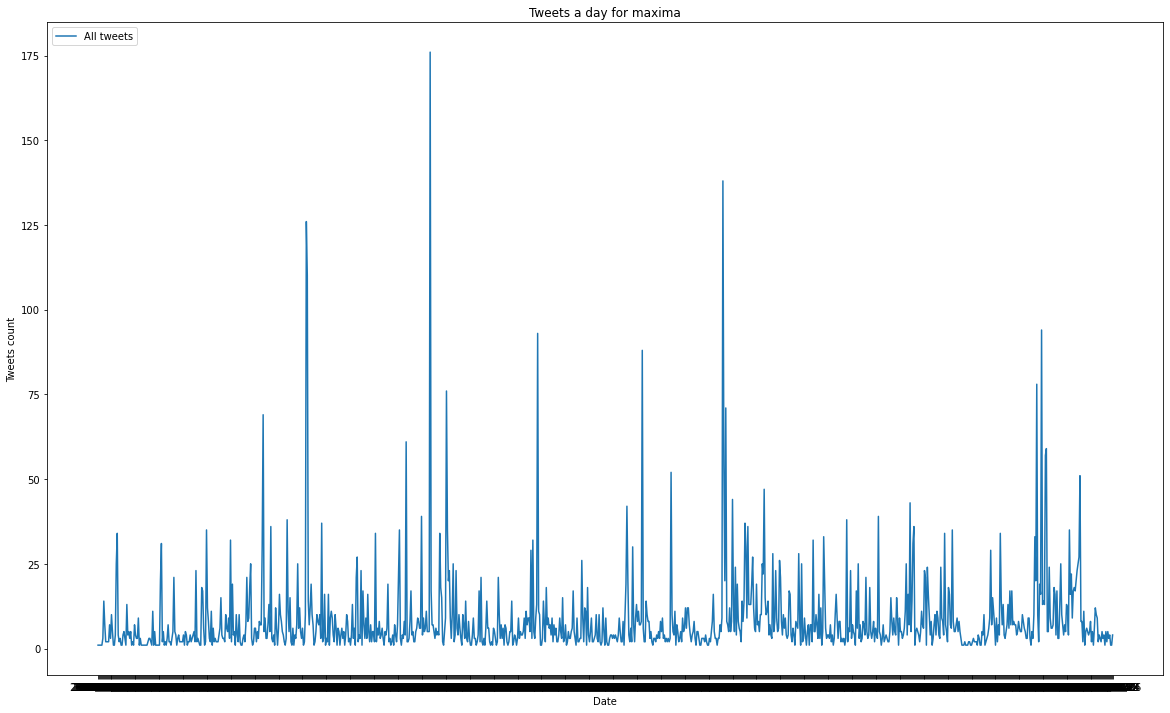

In [22]:
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot([item.date for item in sentimentList], [item.tweetCount for item in sentimentList], label='All tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day for '+brand)
ax.grid(False)
ax.legend(loc='upper left');

In [27]:
def findClosestDate(date):
    dateArr = date.split(",")
    d = datetime(int(dateArr[0]),int(dateArr[1]),int(dateArr[2])) #separated by -
    while(d.strftime('%Y,%m,%d') not in [item.date for item in sentimentList]):
        d += timedelta(days=1)

    return [item.date for item in sentimentList].index(d.strftime('%Y,%m,%d'))

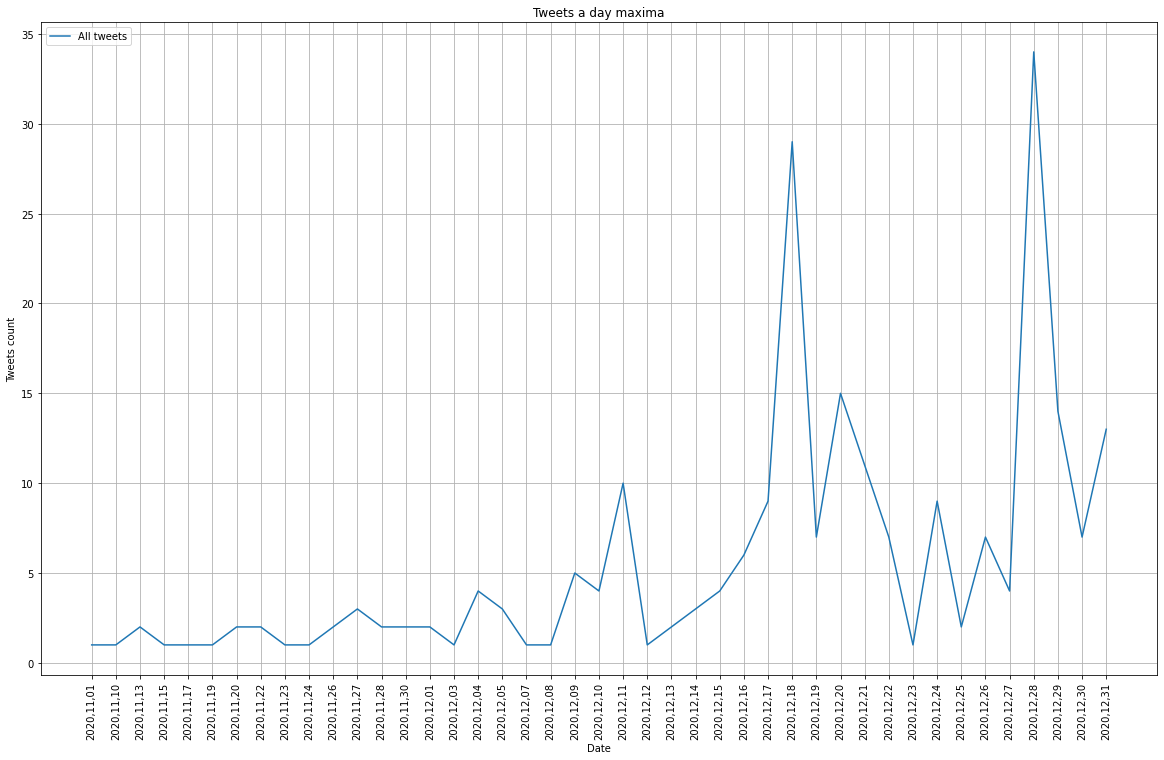

In [29]:
from datetime import datetime

startDate = "2020,11,01"
endDate = "2021,01,01"

startIndex= findClosestDate(startDate)
endIndex= findClosestDate(endDate)
    
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot([item.date for item in sentimentList[startIndex:endIndex]], 
        [item.tweetCount for item in sentimentList[startIndex:endIndex]], label='All tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
plt.xticks(rotation=90)
ax.set_title('Tweets a day '+ brand)
ax.grid(True)
ax.legend(loc='upper left');

# Positive, negative, neutral

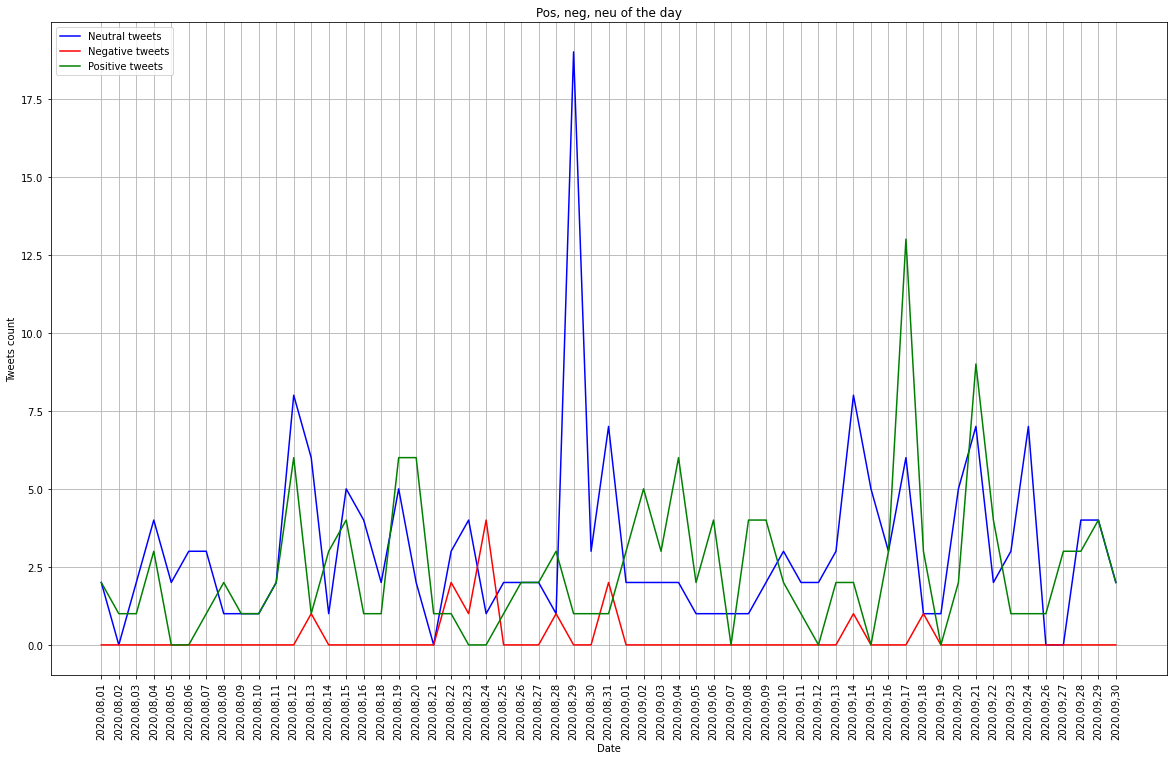

In [37]:
startDate = "2020,08,01"
endDate = "2020,10,01"

startIndex= findClosestDate(startDate)
endIndex= findClosestDate(endDate)
    
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot([item.date for item in sentimentList[startIndex:endIndex]], 
        [item.neutralCount for item in sentimentList[startIndex:endIndex]], label='Neutral tweets', color='b')
ax.plot([item.date for item in sentimentList[startIndex:endIndex]], 
        [item.negativeCount for item in sentimentList[startIndex:endIndex]], label='Negative tweets', color='r')
ax.plot([item.date for item in sentimentList[startIndex:endIndex]], 
        [item.positiveCount for item in sentimentList[startIndex:endIndex]], label='Positive tweets', color='g')

ax.set_xlabel('Date')
plt.xticks(rotation=90)
ax.set_ylabel('Tweets count')
ax.set_title('Pos, neg, neu of the day')
ax.grid(True)
ax.legend(loc='upper left');

# Sentiment (pos - neg)

In [ ]:
# sentimentCounts = []
# for date in dates:
#     i = dates.index(date)
#     sentiment = positiveCounts[i] - negativeCounts[i]
#     sentimentCounts.append(sentiment)
    
# sentimentCounts[:5]

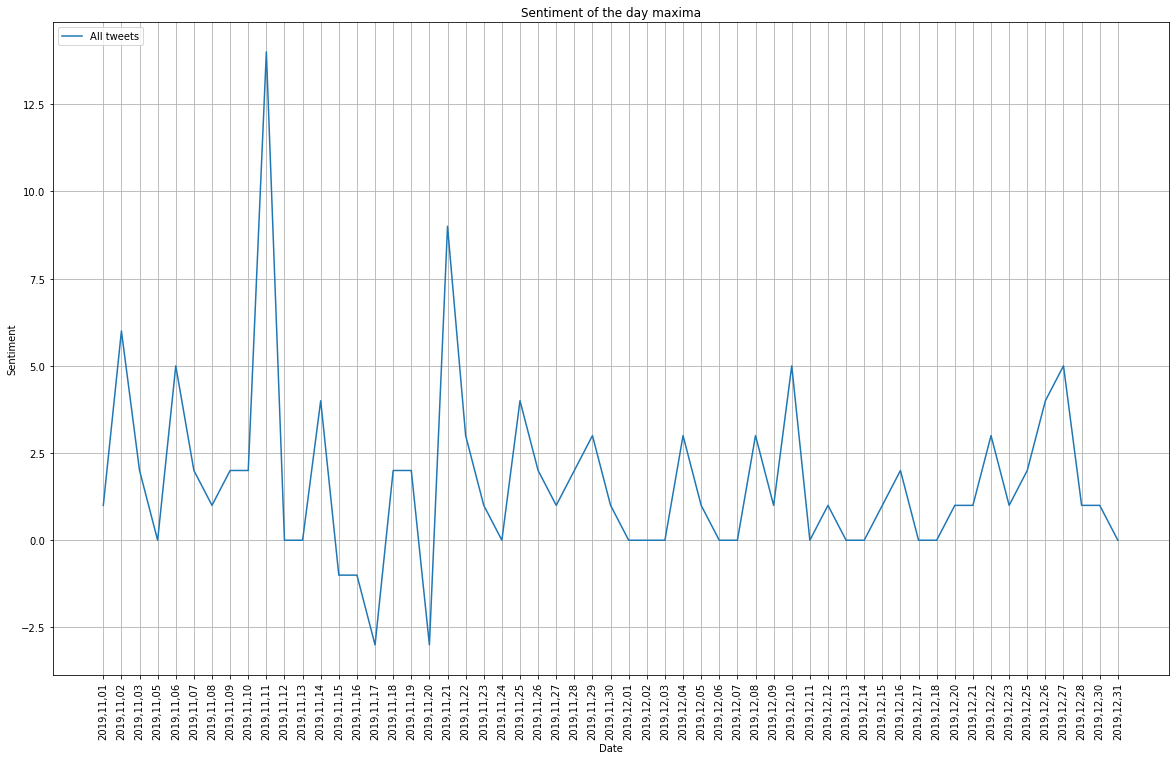

In [41]:
startDate = "2019,11,01"
endDate = "2020,01,01"

startIndex= findClosestDate(startDate)
endIndex= findClosestDate(endDate)
    
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot([item.date for item in sentimentList[startIndex:endIndex]], 
        [(item.positiveCount-item.negativeCount) for item in sentimentList[startIndex:endIndex]], label='All tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
plt.xticks(rotation=90)
ax.set_title('Sentiment of the day '+ brand)
ax.grid(True)
ax.legend(loc='upper left');

# Compare maxima and rimi

In [45]:
brand2 = 'rimi'
brandTweets2 = pd.read_csv('./predictions/'+brand2+'.csv')

brandTweets2 = brandTweets2.sort_values(by="date")
brandTweets2.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,monitoringObjectId1,monitoringObjectId2,queryId,sentiment,retweetCount,label,brand,clean_message,date,lvbert_label
0,@presesklubs @Silina_Elina @ZarinsI @AndrisSpr...,1483990,925746406169641000,2017-11-01T17:28:37,lv,9.257205e+17,4.272831e+09,presesklubs,990886668,Rainers Meiers,...,386,386,625.0,NaN,0,0.0,rimi,MENTION MENTION MENTION MENTION Cik produktīva...,"2017,11,01",0
1,"I'm at Rimi ""Kalnciema"" - @mansrimi in Riga, L...",1498061,926103114477920300,2017-11-02T17:06:03,it,NaN,NaN,NaN,93444470,Iveta Sīle,...,198,198,437.0,NaN,0,NaN,rimi,"I'm at Rimi ""Kalnciema"" - MENTION in Riga, Lat...","2017,11,02",0
2,"@Tele2Latvia pie jums tikai tad, kad mani izme...",1506975,926448378124361700,2017-11-03T15:58:00,lv,9.264411e+17,3.843552e+07,Tele2Latvia,334622732,digidigidong,...,195,195,434.0,NaN,0,NaN,rimi,"MENTION pie jums tikai tad, kad mani izmetīs n...","2017,11,03",1
3,@GirtsKarnitis šorīt Rimi viens pirms manis pi...,1509728,926526719007354900,2017-11-03T21:09:18,lv,9.265254e+17,4.734868e+07,GirtsKarnitis,210595292,Didzis Uzuliņš,...,773,773,1012.0,NaN,0,1.0,rimi,MENTION šorīt Rimi viens pirms manis pirka NMB...,"2017,11,03",1
4,🙄🙄🙄 (@ Rimi Hipermārkets [Bauska] - @mansrimi ...,1511392,926512413373075500,2017-11-03T20:12:27,lv,NaN,NaN,NaN,1565710922,- Linda ♥,...,198,198,437.0,NaN,0,0.0,rimi,🙄🙄🙄 (@ Rimi Hipermārkets [Bauska] - MENTION in...,"2017,11,03",0


In [46]:
class dateSentimentValues: 
    def __init__(self, date, tweetCount, neutralCount, positiveCount, negativeCount): 
        self.date = date 
        self.tweetCount = tweetCount
        self.neutralCount = neutralCount
        self.positiveCount = positiveCount
        self.negativeCount = negativeCount
        
sentimentList2 = []
for index, row in brandTweets2.iterrows():
    existingDate = 0
    if (len(sentimentList)==0):
        if(row['lvbert_label']==0):
            sentimentList2.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
        elif(row['lvbert_label']==1):
            sentimentList2.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
        elif(row['lvbert_label']==2):
            sentimentList2.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))
    else:
        for item in sentimentList2:
            if(item.date == row['date']):
                existingDate = 1
                item.tweetCount += (1 + row['retweetCount'])
                if(row['lvbert_label']==0):
                    item.neutralCount+=1
                elif(row['lvbert_label']==1):
                    item.positiveCount+=1
                elif(row['lvbert_label']==2):
                    item.negativeCount+=1
                break
        if(existingDate==0):
            if(row['lvbert_label']==0):
                sentimentList2.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
            elif(row['lvbert_label']==1):
                sentimentList2.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
            elif(row['lvbert_label']==2):
                sentimentList2.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))

## Tweets in a day

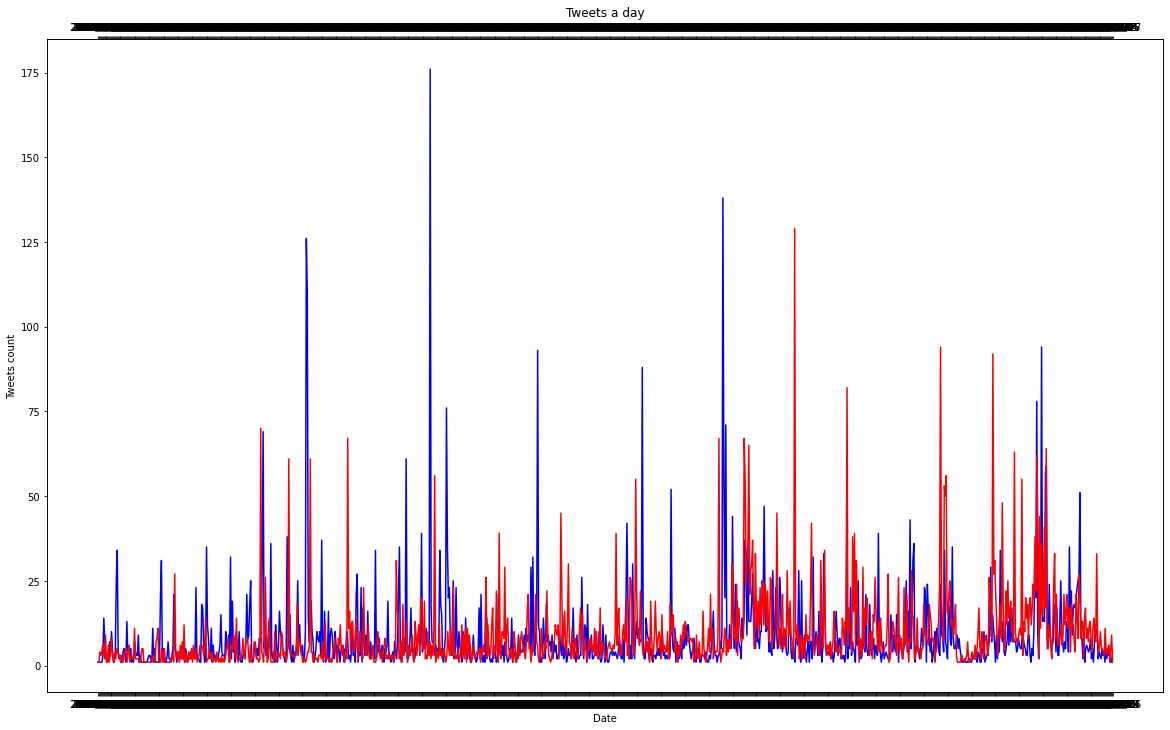

In [47]:
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot([item.date for item in sentimentList], [item.tweetCount for item in sentimentList], label='Maxima tweets', color='b')
ax1 = ax.twiny()
ax1.plot([item.date for item in sentimentList2], [item.tweetCount for item in sentimentList2], label='Rimi tweets', color='r')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(False)

In [48]:
def findClosestDateData(date, data):
    dateArr = date.split(",")
    d = datetime(int(dateArr[0]),int(dateArr[1]),int(dateArr[2])) #separated by -
    while(d.strftime('%Y,%m,%d') not in [item.date for item in data]):
        d += timedelta(days=1)

    return [item.date for item in data].index(d.strftime('%Y,%m,%d'))

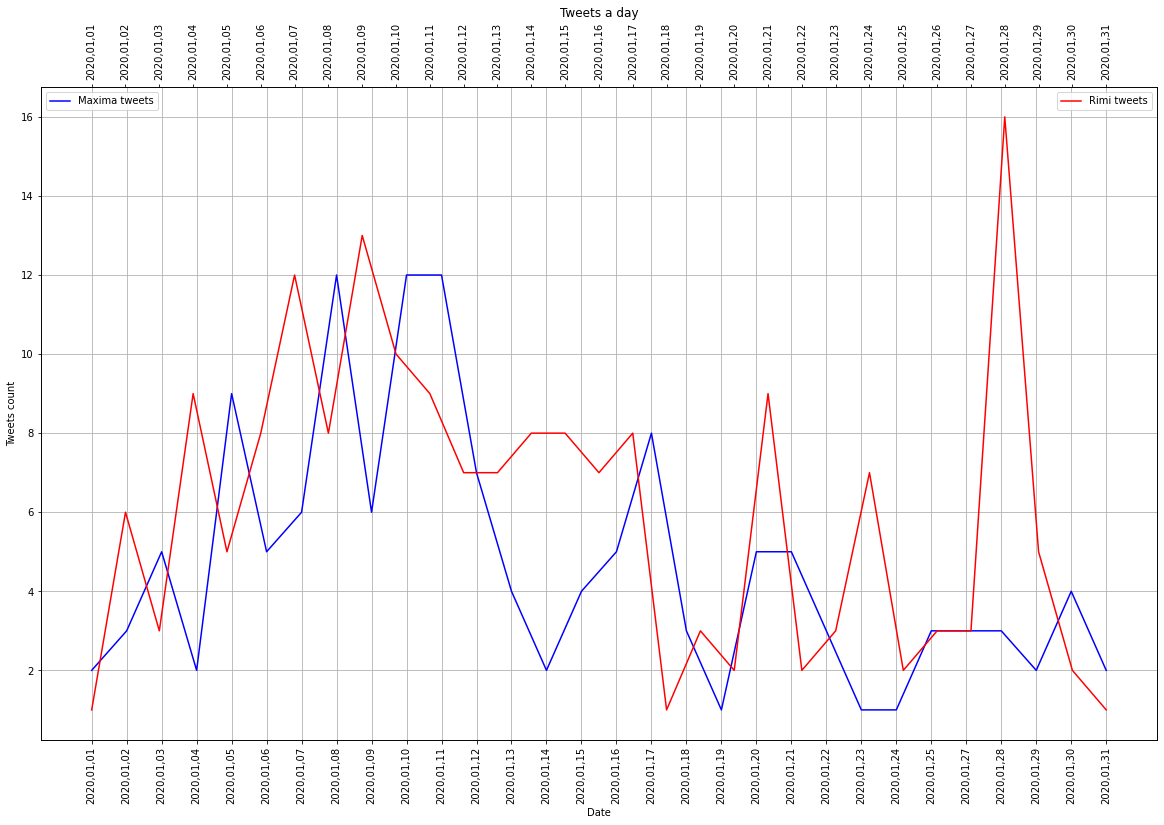

In [51]:
startDate = "2020,01,01"
endDate = "2020,02,01"

startIndex= findClosestDateData(startDate, sentimentList)
endIndex= findClosestDateData(endDate,sentimentList)

startIndex2= findClosestDateData(startDate,sentimentList2)
endIndex2= findClosestDateData(endDate,sentimentList2)

plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))
plt.xticks(rotation=90)

ax.plot([item.date for item in sentimentList[startIndex:endIndex]], 
        [item.tweetCount for item in sentimentList[startIndex:endIndex]], label='Maxima tweets', color='b')
ax1 = ax.twiny()
ax1.plot([item.date for item in sentimentList2[startIndex2:endIndex2]], 
         [item.tweetCount for item in sentimentList2[startIndex2:endIndex2]], label='Rimi tweets', color='r')

ax.set_xlabel('Date')
plt.xticks(rotation=90)

ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(True)
ax.legend(loc='upper left');
ax1.legend(loc=0);

# Sentiment (pos - neg)

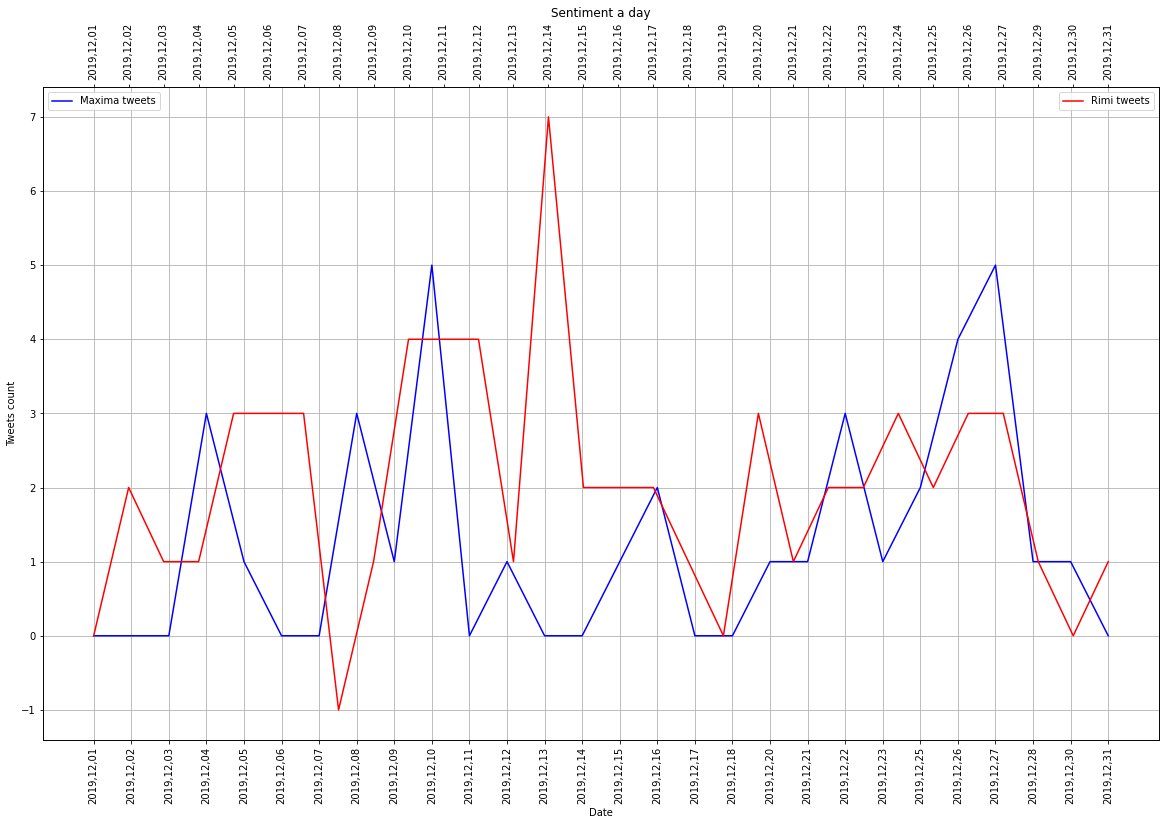

In [53]:
startDate = "2019,12,01"
endDate = "2020,01,01"

startIndex= findClosestDateData(startDate, sentimentList)
endIndex= findClosestDateData(endDate,sentimentList)

startIndex2= findClosestDateData(startDate,sentimentList2)
endIndex2= findClosestDateData(endDate,sentimentList2)

plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))
plt.xticks(rotation=90)

ax.plot([item.date for item in sentimentList[startIndex:endIndex]], 
        [(item.positiveCount-item.negativeCount) for item in sentimentList[startIndex:endIndex]], label='Maxima tweets', color='b')
ax1 = ax.twiny()
ax1.plot([item.date for item in sentimentList2[startIndex2:endIndex2]], 
         [(item.positiveCount-item.negativeCount) for item in sentimentList2[startIndex2:endIndex2]], label='Rimi tweets', color='r')

ax.set_xlabel('Date')
plt.xticks(rotation=90)

ax.set_ylabel('Tweets count')
ax.set_title('Sentiment a day')
ax.grid(True)
ax.legend(loc='upper left');
ax1.legend(loc=0);

# By month

In [54]:
def findClosestMonth(date):
    dateArr = date.split(",")
    d = datetime(int(dateArr[0]),int(dateArr[1]),int(dateArr[2])) #separated by -
    while(d.strftime('%Y,%m') not in months):
        d += timedelta(months=1)

    return months.index(d.strftime('%Y,%m'))

In [55]:
sentimentByMonthList = []

for index, row in brandTweets.iterrows():
    existingDate = 0
    dateArr = row['date'].split(",")
    month = dateArr[0]+","+dateArr[1]
    if (len(sentimentByMonthList)==0):
        if(row['lvbert_label']==0):
            sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
        elif(row['lvbert_label']==1):
            sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
        elif(row['lvbert_label']==2):
            sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))
    else:
        for item in sentimentByMonthList:
            if(item.date == month):
                existingDate = 1
                item.tweetCount += (1 + row['retweetCount'])
                if(row['lvbert_label']==0):
                    item.neutralCount+=1
                elif(row['lvbert_label']==1):
                    item.positiveCount+=1
                elif(row['lvbert_label']==2):
                    item.negativeCount+=1
                break
        if(existingDate==0):
            if(row['lvbert_label']==0):
                sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
            elif(row['lvbert_label']==1):
                sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
            elif(row['lvbert_label']==2):
                sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))

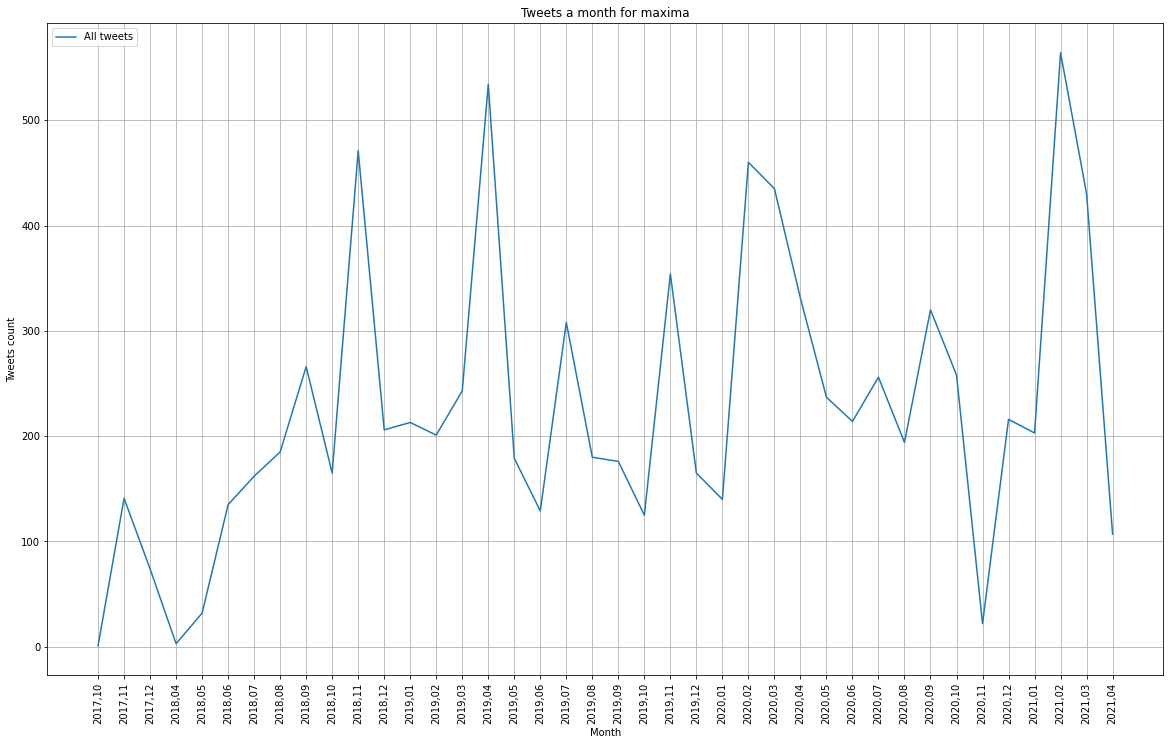

In [56]:
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot([item.date for item in sentimentByMonthList], [item.tweetCount for item in sentimentByMonthList], label='All tweets')

ax.set_xlabel('Month')
plt.xticks(rotation=90)
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a month for '+brand)
ax.grid(True)
ax.legend(loc='upper left');

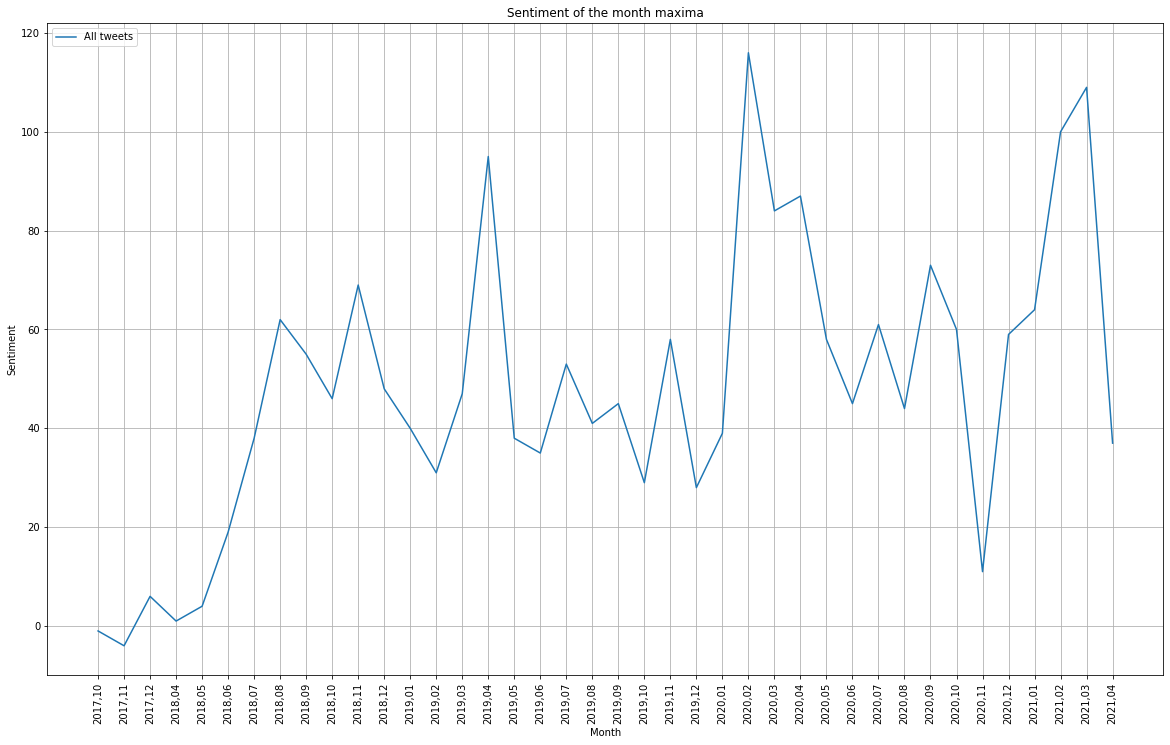

In [57]:
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot([item.date for item in sentimentByMonthList], 
        [(item.positiveCount-item.negativeCount) for item in sentimentByMonthList], label='All tweets')

ax.set_xlabel('Month')
ax.set_ylabel('Sentiment')
plt.xticks(rotation=90)
ax.set_title('Sentiment of the month '+ brand)
ax.grid(True)
ax.legend(loc='upper left');

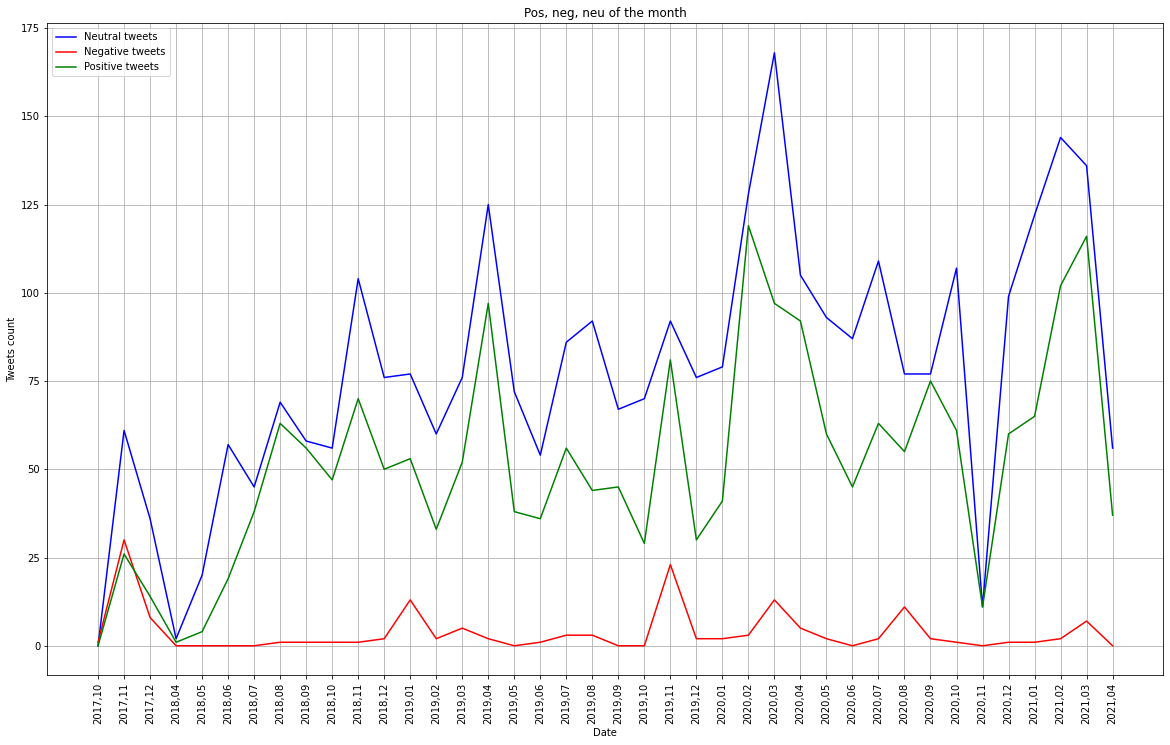

In [58]:
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot([item.date for item in sentimentByMonthList], 
        [item.neutralCount for item in sentimentByMonthList], label='Neutral tweets', color='b')
ax.plot([item.date for item in sentimentByMonthList], 
        [item.negativeCount for item in sentimentByMonthList], label='Negative tweets', color='r')
ax.plot([item.date for item in sentimentByMonthList], 
        [item.positiveCount for item in sentimentByMonthList], label='Positive tweets', color='g')

ax.set_xlabel('Date')
plt.xticks(rotation=90)
ax.set_ylabel('Tweets count')
ax.set_title('Pos, neg, neu of the month')
ax.grid(True)
ax.legend(loc='upper left');